# Data gathered from all BRCA patients
* All BRCA cancer samples were downloaded for TCGA resulting in expression profiles for 1102 patients
* Normal data was downloaded for 114 patients
    * For the 20532 genes median expression values were calculated.  These will function as baseline expression for the 1102 patients
* Fold change calculated for 1102 patients as log2(cancer exp/median normal exp) per 20532 genes.
* This allows for near complete overlap with protein data (106 patients, out of about 108)

# Normalizing protein and mRNA values with z-score

One thing that I want to do is make sure we equivalently scale the fold changes for protein and mRNA expression.  Since these two facets of data were normalized by separate means, the scaling may be impacted in such a fashion that ranges are not equivalent.

I will take the originally calculated, individual-level fold changes and apply a z-score standardization to it:

$$z = \frac{x – \mu}{\sigma}$$

This should normalize the scale of both so more accurate calculations can be made.  First we will observe the patient level, z-score normalized fold changes and plot them against each other.

In [3]:
%cd ../../../bioinfo/combined_attempt/output/

/mnt/bay1/bioinfo/combined_attempt/output


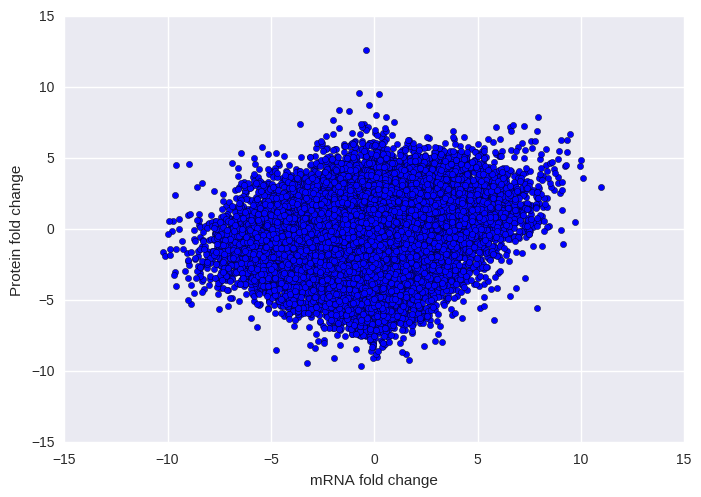

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# calculate z score as above:
# value minus the mean of the vector over the S.D.
def calculate_z(val,val_mean,val_sd):
    num   = val - val_mean
    denom = val_sd
    # make sure the denominator is not 0
    if denom != 0:
        return num/denom
    else:
        return np.nan
    
df           = pd.read_csv(open("../data/intermediate/merged_protein_mrna.txt",'r'),delimiter="\t")

# Calculate mean value and SD for mrna/protein
mean_prot = np.mean(df['prot'])
mean_mrna = np.mean(df['mrna'])
sd_prot   = np.std(df['prot'])
sd_mrna   = np.std(df['mrna'])

df['prot_z'] = df['prot'].apply(lambda x: calculate_z(x,mean_prot,sd_prot))
df['mrna_z'] = df['mrna'].apply(lambda x: calculate_z(x,mean_mrna,sd_mrna))

# plot the results
plt.scatter(df['mrna_z'],df['prot_z'])
plt.ylabel("Protein fold change")
plt.xlabel("mRNA fold change")
plt.show()

We can see the axes are consistent for both mRNA and protein.  This indicates a decent method of standardization between the two datasets.  The plot emphasizes the distribution and variability of mRNA and protein fold changes.  It also suggests that the fold change of one 'omics data source does not necessarily reflect that of the other.  

## Normalizing and plotting of mean data

Next to simplify the previous plot, we calculate the mean protein and mRNA fold changes for each of the genes, then use z-scoring to standardize them.  The x-axis is again mRNA-standardized fold change and the y-axis is the protein-standardized fold change.  

### All genome

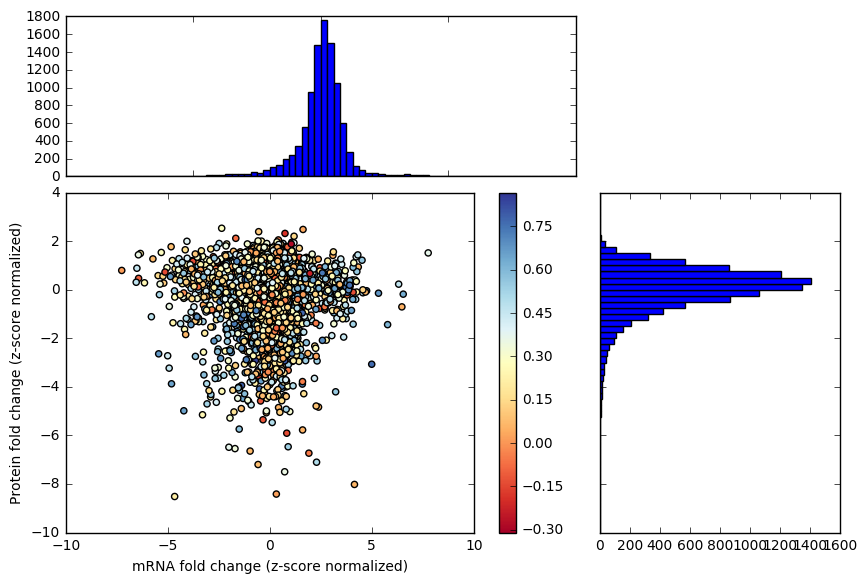

In [5]:
from matplotlib.ticker import NullFormatter

# calculate z score as above:
# value minus the mean of the vector over the S.D.
def calculate_z(val,val_mean,val_sd):
    num   = val - val_mean
    denom = val_sd
    # make sure the denominator is not 0
    if denom != 0:
        return num/denom
    else:
        return np.nan
# Calculate mean value and SD for mrna/protein    
df2 = pd.read_csv(open("../data/output/pearsonr_prot_mrna.txt",'r'),delimiter="\t")

mean_prot = np.mean(df2['prot_mean'])
mean_mrna = np.mean(df2['mrna_mean'])
sd_prot   = np.std(df2['prot_mean'])
sd_mrna   = np.std(df2['mrna_mean'])


df2['prot_z'] = df2['prot_mean'].apply(lambda x: calculate_z(x,mean_prot,sd_prot))
df2['mrna_z'] = df2['mrna_mean'].apply(lambda x: calculate_z(x,mean_mrna,sd_mrna))
cm = plt.cm.get_cmap('RdYlBu')



# definitions for the axes
nullfmt = NullFormatter()         # no labels

left, width = 0.2, 0.85
bottom, height = 0.2, 0.85
bottom_h = left_h = left + width + 0.04
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.4]
rect_histy = [left_h, bottom, 0.4, height]
axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
binwidth = 0.25
xymax = np.max([np.max(np.fabs(df2['mrna_z'])), np.max(np.fabs(df2['prot_z']))])
lim = (int(xymax/binwidth) + 1) * binwidth

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(df2['mrna_z'], bins=bins)
axHisty.hist(df2['prot_z'], bins=bins, orientation='horizontal')

s = axScatter.scatter(df2['mrna_z'],df2['prot_z'],c=df2['stat'],cmap=cm)

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())
axScatter.set_xlabel("mRNA fold change (z-score normalized)")
axScatter.set_ylabel("Protein fold change (z-score normalized)")

plt.colorbar(mappable=s,ax=axScatter)
plt.show()

### 20q region

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (32,34,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


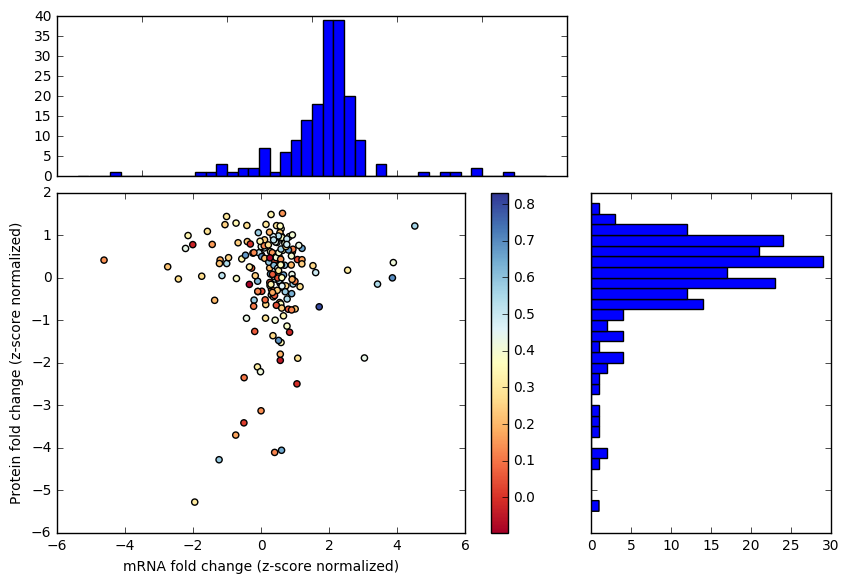

In [6]:
from matplotlib.ticker import NullFormatter
def location_check(loc_string):
    if '20q' in loc_string:
        return 1
    else:
        return 0
gene_annotation = pd.read_csv(open("../data/staging/hgnc_complete_set.txt",'r'),delimiter="\t")
df2_annotated = pd.merge(gene_annotation[['symbol','location','location_sortable']],df2,left_on='symbol',right_on='gene')
df2_annotated['in_region'] = df2_annotated['location_sortable'].map(lambda x: (location_check(x)))

df3 = df2_annotated[df2_annotated['in_region'] == 1].reset_index()
#df3.to_csv(open('data/output/20q_genes_and_exp.txt','w'),sep="\t",index=False)

cm = plt.cm.get_cmap('RdYlBu')

 #definitions for the axes
nullfmt = NullFormatter()         # no labels
left, width = 0.2, 0.85
bottom, height = 0.2, 0.85
bottom_h = left_h = left + width + 0.04
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.4]
rect_histy = [left_h, bottom, 0.4, height]
axScatter2 = plt.axes(rect_scatter)
axHistx2 = plt.axes(rect_histx)
axHisty2 = plt.axes(rect_histy)
axHistx2.xaxis.set_major_formatter(nullfmt)
axHisty2.yaxis.set_major_formatter(nullfmt)
binwidth = 0.25
xymax = np.max([np.max(np.fabs(df3['mrna_z'])), np.max(np.fabs(df3['prot_z']))])
lim = (int(xymax/binwidth) + 1) * binwidth

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx2.hist(df3['mrna_z'], bins=bins)
axHisty2.hist(df3['prot_z'], bins=bins, orientation='horizontal')

s = axScatter2.scatter(df3['mrna_z'],df3['prot_z'],c=df3['stat'],cmap=cm)

axHistx2.set_xlim(axScatter2.get_xlim())
axHisty2.set_ylim(axScatter2.get_ylim())
axScatter2.set_xlabel("mRNA fold change (z-score normalized)")
axScatter2.set_ylabel("Protein fold change (z-score normalized)")

plt.colorbar(mappable=s,ax=axScatter2)
plt.show()

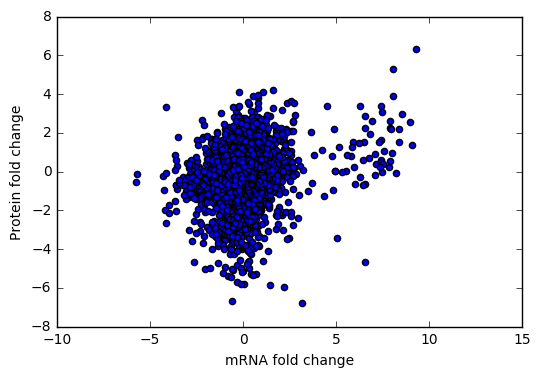

['CHGB' 'CST1' 'INSM1']
['A8-A06Z' 'AO-A12B' 'AN-A0FK' 'D8-A13Y' 'C8-A12T' 'C8-A12U' 'A2-A0EV'
 'D8-A142' 'A2-A0SW' 'A2-A0T6' 'E2-A15A' 'C8-A12Q' 'A8-A079' 'A2-A0YF'
 'BH-A0DD' 'BH-A0E9' 'A2-A0YG' 'E2-A150' 'BH-A0C7' 'A7-A0CD' 'C8-A12W'
 'BH-A0C0' 'A2-A0YC' 'A7-A0CJ' 'A2-A0YL' 'C8-A134' 'C8-A12L' 'A2-A0EX'
 'BH-A0DG' 'AN-A0AS' 'A8-A08Z' 'AR-A0TX' 'AO-A0JE' 'A2-A0T2' 'AN-A0AJ'
 'AO-A0JM' 'C8-A12V' 'A8-A08G' 'AO-A12D' 'AN-A04A' 'BH-A0AV' 'AR-A0TT'
 'AR-A1AQ' 'AR-A0TV' 'C8-A12Z' 'AO-A0JJ' 'BH-A0HP' 'AR-A1AP' 'AR-A1AW'
 'AR-A1AV' 'AO-A0J9' 'BH-A0E0' 'BH-A18U' 'A2-A0EQ' 'BH-A18V' 'A7-A13F'
 'C8-A12P' 'BH-A0C1' 'A2-A0EY' 'C8-A138' 'E2-A154' 'BH-A0BZ' 'A8-A076'
 'AO-A126' 'E2-A10A' 'BH-A18Q' 'C8-A130' 'A2-A0YD' 'A2-A0D1']


In [7]:
from matplotlib.ticker import NullFormatter
def location_check(loc_string):
    if '20p' in loc_string:
        return 1
    else:
        return 0
def location_parse(loc_string):
    if 'q' in loc_string:
        return loc_string.split('q')[0]+"q"
    else:
        return loc_string.split('p')[0]+"p"
gene_annotation = pd.read_csv(open("../data/staging/hgnc_complete_set.txt",'r'),delimiter="\t")
df2_annotated = pd.merge(gene_annotation[['symbol','location','location_sortable']],df,left_on='symbol',right_on='Gene')
df2_annotated['location_trunc'] = df2_annotated['location_sortable'].map(lambda x: location_parse(x))
df2_annotated['in_region'] = df2_annotated['location_sortable'].map(lambda x: (location_check(x)))

df3 = df2_annotated[df2_annotated['in_region'] == 1]
#df3.to_csv(open('data/output/20q_genes_and_exp.txt','w'),sep="\t",index=False)
plt.scatter(df3['mrna_z'],df3['prot_z'])
plt.ylabel("Protein fold change")
plt.xlabel("mRNA fold change")
plt.show()

plt.show()
print df3['Gene'][df3['mrna_z'] > 5].unique()
print df3['Sample'][df3['mrna_z'] > 5].unique()

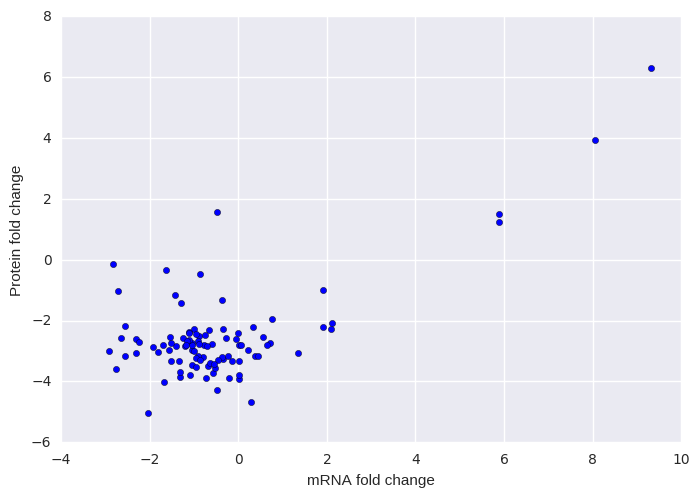

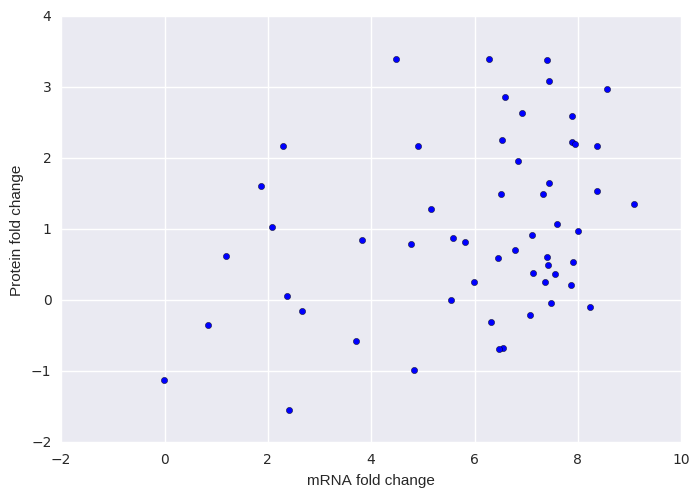

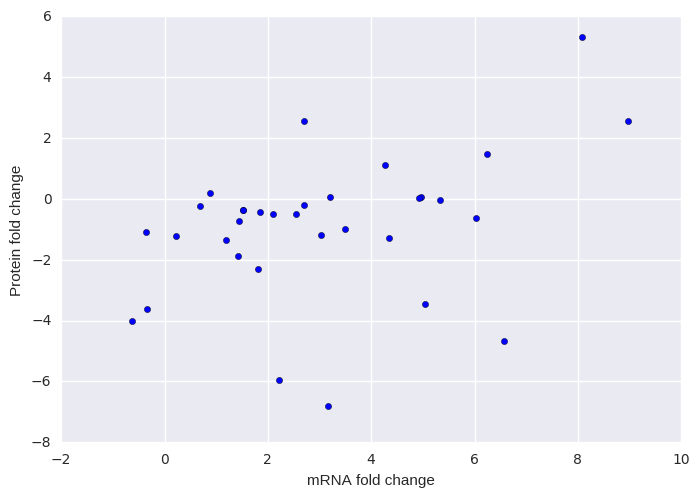

['INSM1']
['BH-A0DD' 'A2-A0YC' 'A8-A06Z' 'A2-A0D1' 'A2-A0EX' 'AO-A12B' 'BH-A18U'
 'D8-A13Y']


In [40]:
from matplotlib.ticker import NullFormatter
def location_check(loc_string):
    if '20p' in loc_string:
        return 1
    else:
        return 0
def location_parse(loc_string):
    if 'q' in loc_string:
        return loc_string.split('q')[0]+"q"
    else:
        return loc_string.split('p')[0]+"p"
gene_annotation = pd.read_csv(open("../data/staging/hgnc_complete_set.txt",'r'),delimiter="\t")
df2_annotated = pd.merge(gene_annotation[['symbol','location','location_sortable']],df,left_on='symbol',right_on='Gene')
df2_annotated['location_trunc'] = df2_annotated['location_sortable'].map(lambda x: location_parse(x))
df2_annotated['in_region'] = df2_annotated['location_sortable'].map(lambda x: (location_check(x)))

df3 = df2_annotated[(df2_annotated['in_region'] == 1) & (df2_annotated['Gene'] == 'CHGB')]
#df3.to_csv(open('data/output/20q_genes_and_exp.txt','w'),sep="\t",index=False)
plt.scatter(df3['mrna_z'],df3['prot_z'])
plt.ylabel("Protein fold change")
plt.xlabel("mRNA fold change")
plt.show()

plt.show()

df3 = df2_annotated[(df2_annotated['in_region'] == 1) & (df2_annotated['Gene'] == 'CST1')]
#df3.to_csv(open('data/output/20q_genes_and_exp.txt','w'),sep="\t",index=False)
plt.scatter(df3['mrna_z'],df3['prot_z'])
plt.ylabel("Protein fold change")
plt.xlabel("mRNA fold change")
plt.show()

df3 = df2_annotated[(df2_annotated['in_region'] == 1) & (df2_annotated['Gene'] == 'INSM1')]
#df3.to_csv(open('data/output/20q_genes_and_exp.txt','w'),sep="\t",index=False)
plt.scatter(df3['mrna_z'],df3['prot_z'])
plt.ylabel("Protein fold change")
plt.xlabel("mRNA fold change")
plt.show()

print df3['Gene'][df3['mrna_z'] > 5].unique()

print df3['Sample'][df3['mrna_z'] > 5].unique()

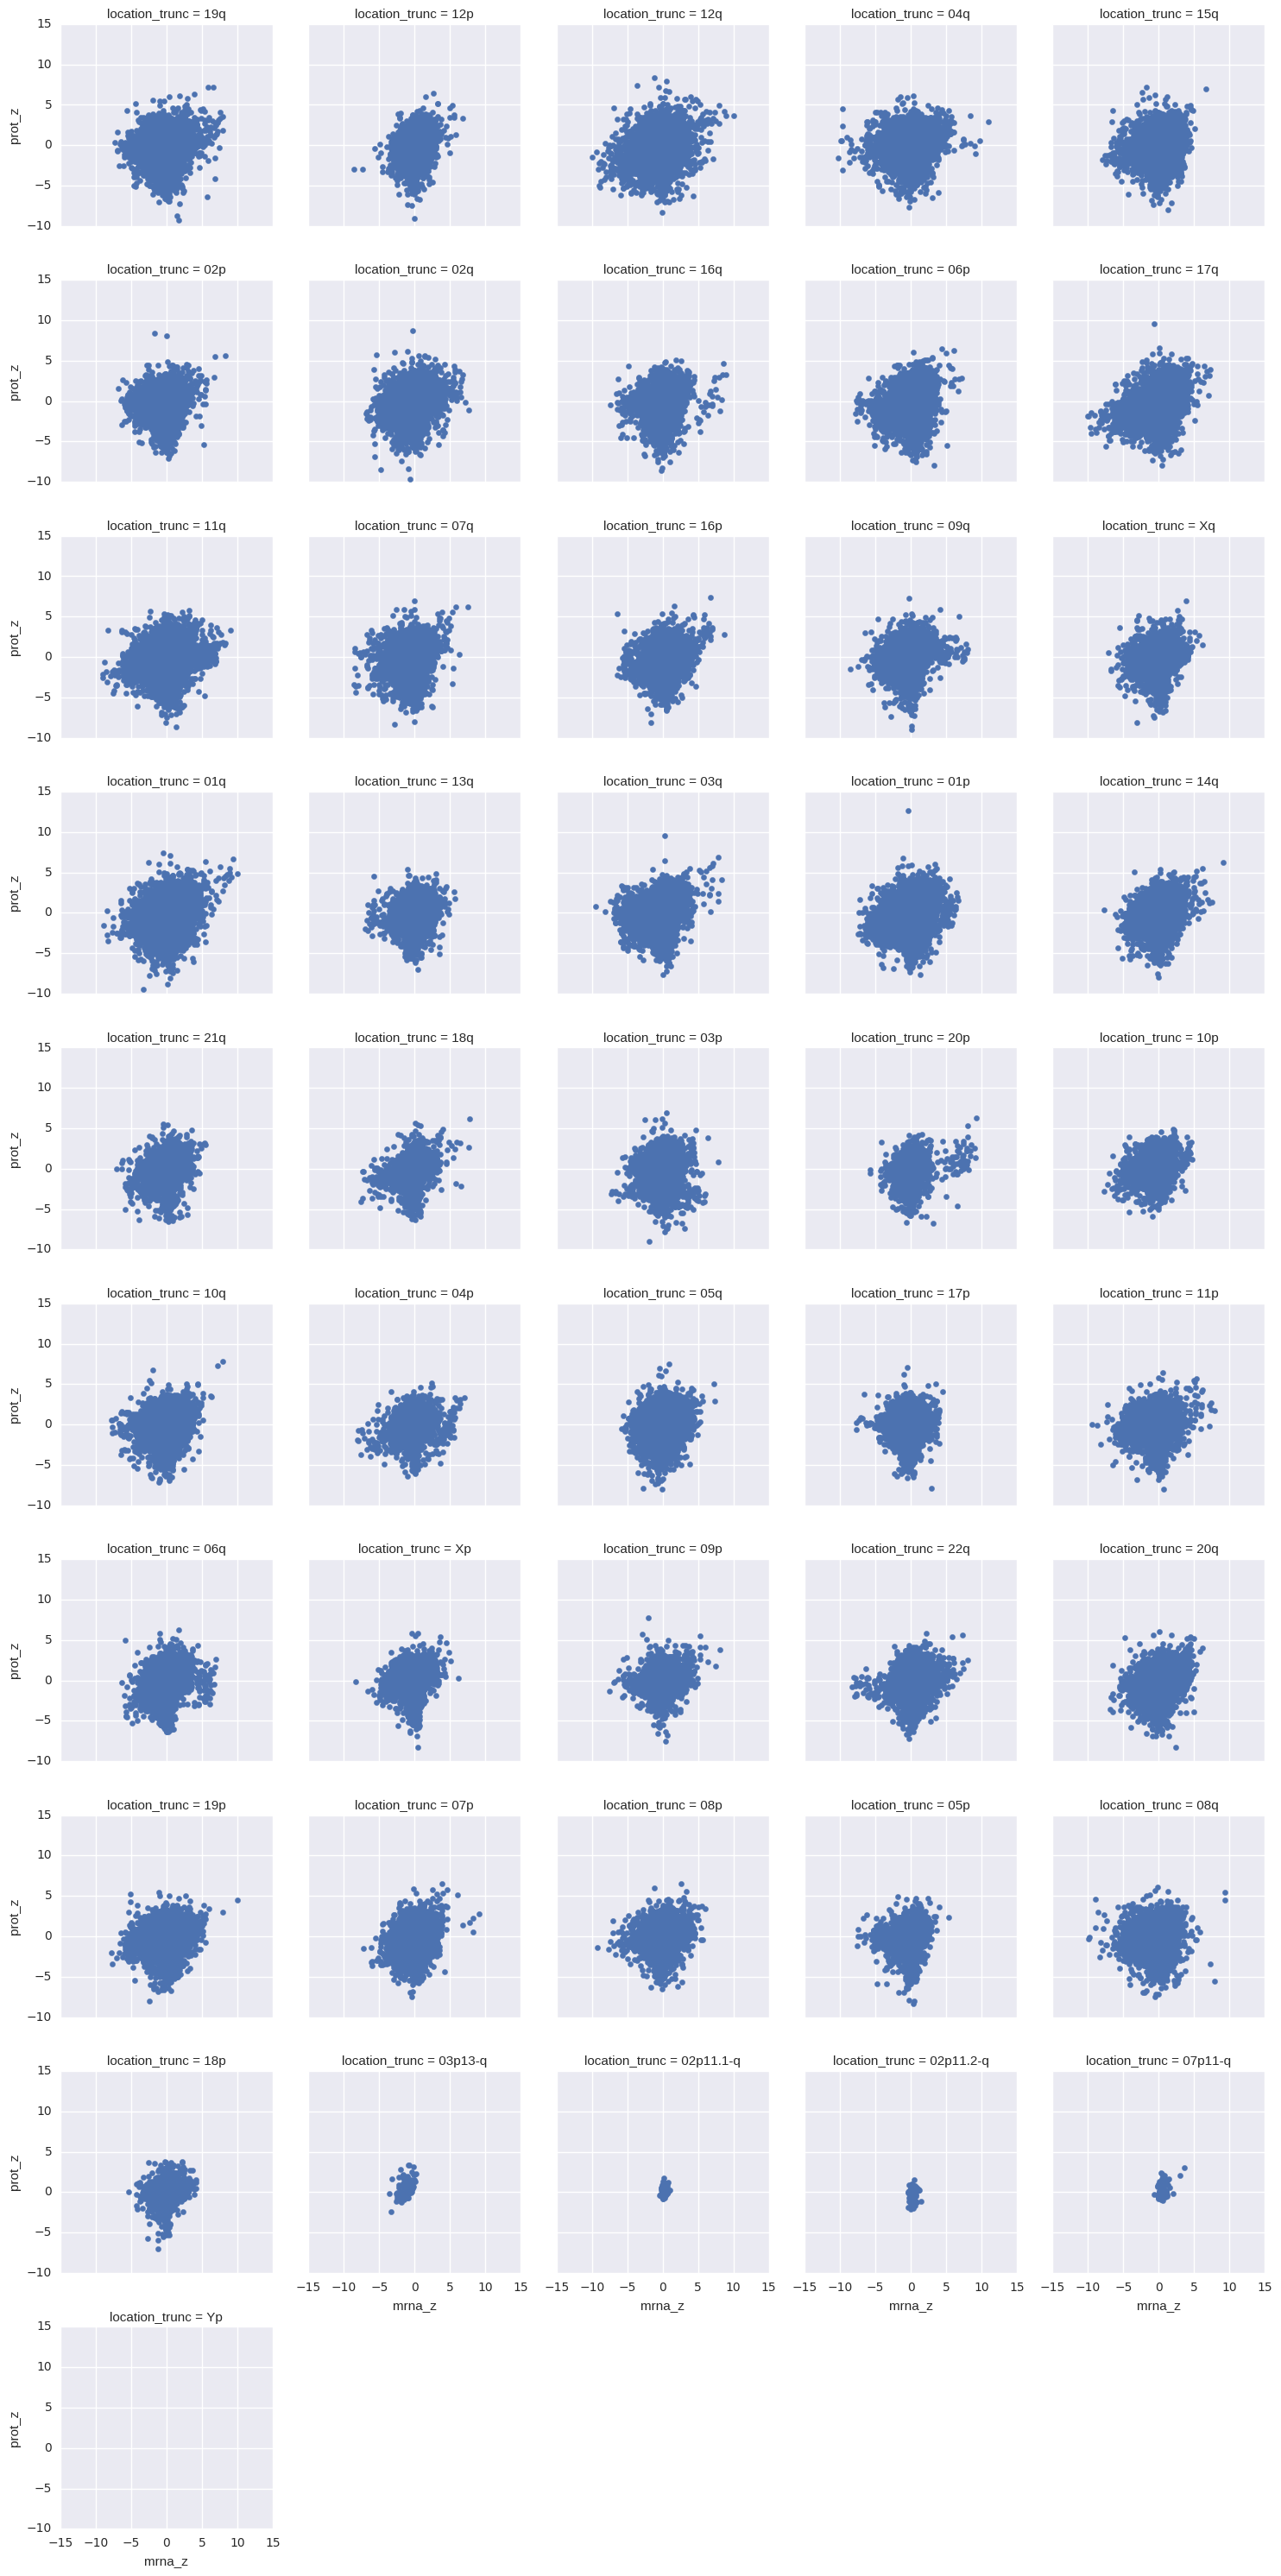

In [16]:
grid1.map(plt.scatter, 'mrna_z', 'prot_z')
sns.plt.show()

In [34]:
df.head()

,Gene,Sample,prot,mrna,prot_z,mrna_z
0,A1BG,A2-A0D0,0.761778,-1.750297,1.180328,-1.067542
1,A2M,A2-A0D0,0.748086,1.836439,1.160142,1.238602
2,A2ML1,A2-A0D0,-2.222585,-0.831915,-3.219604,-0.477055
3,AAAS,A2-A0D0,1.375898,0.390735,2.085743,0.309066
4,AACS,A2-A0D0,-0.195034,0.754511,-0.230327,0.542961


### CNV data and fold-change

For now this is still the segment mean, I'll do a conversion to the proper CNV call a bit later.  Right now I want to verify that the data can be joined and presented.

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (32,34,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


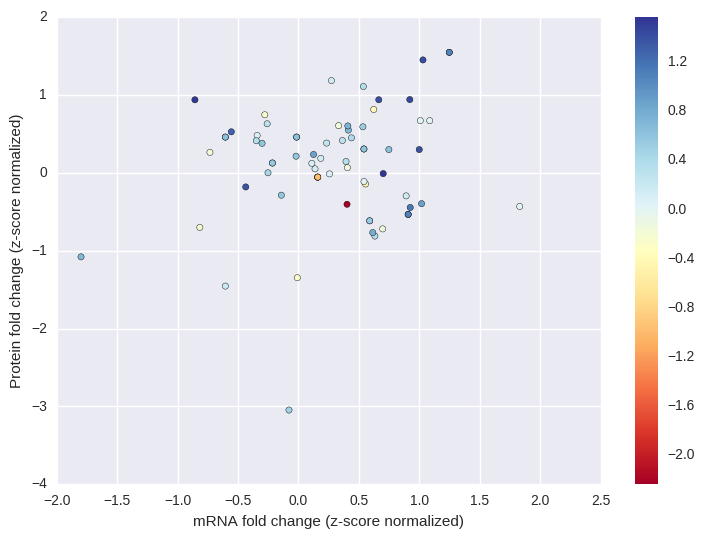

In [5]:
from matplotlib.ticker import NullFormatter
import matplotlib.pyplot as plt

def location_check(loc_string):
    if '20q' in loc_string:
        return 1
    else:
        return 0
gene_annotation = pd.read_csv(open("../data/staging/hgnc_complete_set.txt",'r'),delimiter="\t")
df2_annotated = pd.merge(gene_annotation[['symbol','location','location_sortable']],df,left_on='symbol',right_on='Gene')
df2_annotated['in_region'] = df2_annotated['location_sortable'].map(lambda x: (location_check(x)))

annotated_cnv = pd.read_csv(open("../data/intermediate/cnv_data_unpivot_annotated.txt",'r'),
                           sep="\t")
annotated_cnv.head()
annotated_cnv['barcode'] = annotated_cnv['barcode'].map(lambda x: x.replace('TCGA-',''))

df2_w_cnv = pd.merge(df2_annotated,annotated_cnv,left_on=["Sample","symbol"],right_on=["barcode","gene"],how='left')
df5 = df2_w_cnv[df2_w_cnv['in_region'] == 1].reset_index()
#df3.to_csv(open('data/output/20q_genes_and_exp.txt','w'),sep="\t",index=False)

cm = plt.cm.get_cmap('RdYlBu')

#definitions for the axes
#nullfmt = NullFormatter()         # no labels
left, width = 0.2, 0.85
bottom, height = 0.2, 0.85
bottom_h = left_h = left + width + 0.04
rect_scatter = [left, bottom, width, height]
axScatter2 = plt.axes(rect_scatter)

binwidth = 0.25
xymax = np.max([np.max(np.fabs(df5['mrna_z'])), np.max(np.fabs(df5['prot_z']))])
lim = (int(xymax/binwidth) + 1) * binwidth

bins = np.arange(-lim, lim + binwidth, binwidth)


s = axScatter2.scatter(df5['mrna_z'],df5['prot_z'],c=df5['Segment_Mean'],cmap=cm)


axScatter2.set_xlabel("mRNA fold change (z-score normalized)")
axScatter2.set_ylabel("Protein fold change (z-score normalized)")

labels = list(df5['Gene'])

plt.colorbar(mappable=s,ax=axScatter2)
plt.show()

In [53]:
df5.columns

Index([u'index', u'symbol', u'location', u'location_sortable', u'Gene',
       u'Sample_x', u'prot', u'mrna', u'prot_z', u'mrna_z', u'in_region',
       u'Sample_y', u'Chromosome', u'Start', u'End', u'Num_Probes',
       u'Segment_Mean', u'barcode', u'gene'],
      dtype='object')

42


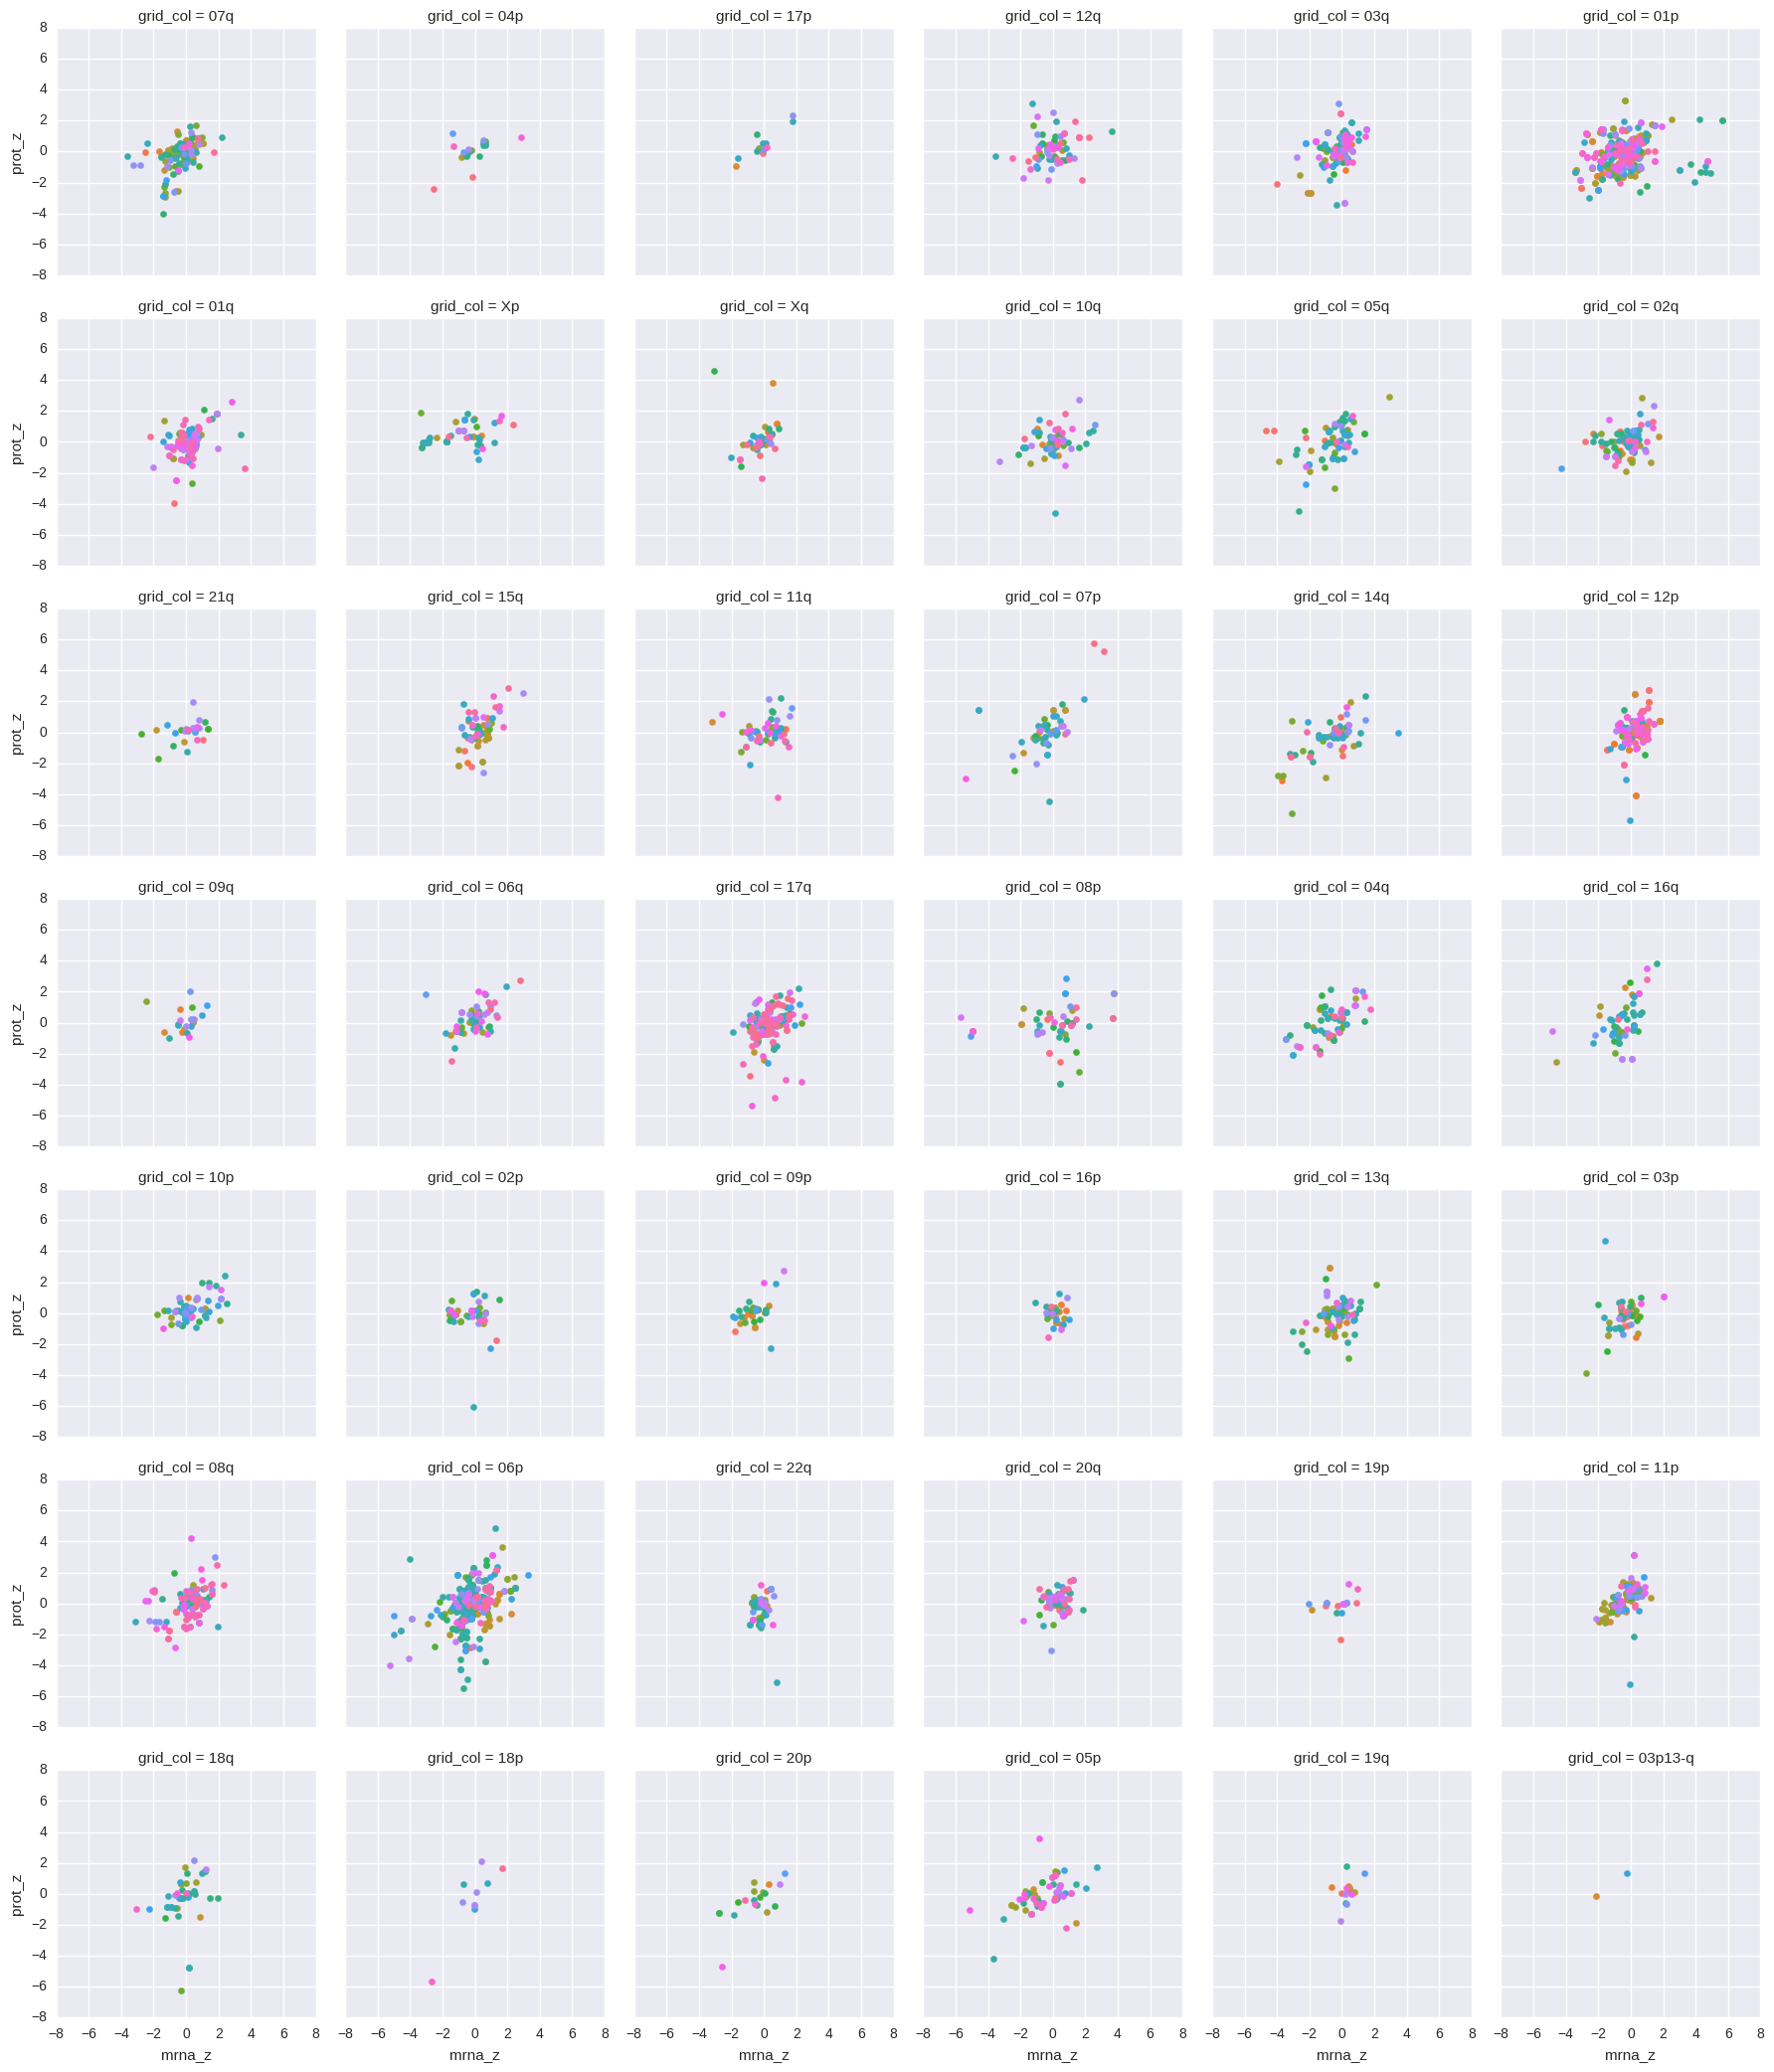

In [16]:
def location_parse(loc_string):
    if 'q' in loc_string:
        return loc_string.split('q')[0]+"q"
    else:
        return loc_string.split('p')[0]+"p"
df2_w_cnv = df2_w_cnv[~df2_w_cnv['Segment_Mean'].isnull()]
df2_w_cnv['grid_col'] = df2_w_cnv['location_sortable'].map(lambda x: location_parse(x))
print len(df2_w_cnv['grid_col'].unique())
grid1 = sns.FacetGrid(df2_w_cnv, col='grid_col',col_wrap=6,hue="Segment_Mean")
grid1.map(plt.scatter, 'mrna_z', 'prot_z')
sns.plt.show()